# Yarına NOT (09.02.25)

Saatlik ve 4 saatlik verilerde tahmin yapmayı denemek.  (RSI a dikkat etmek gerekiyor).

Modeller üzerine hala düzgün bir süreç yok ancak yine de denemeye devam etmek.

Finance videosu (Youtube) üzerinden ilerlemek.

Dua etmek .

#Pip & Import

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files
import pandas as pd
import datetime
import time
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Processing

In [ ]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate rolling averages
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    # Compute Relative Strength (RS)
    rs = avg_gain / avg_loss
    # Compute RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Deneme datayı alıyoruz
prices = pd.read_csv("10bin-row-Denemelik-2025-02-06.csv")  # Placeholder for your dataset
prices.set_index('Timestamp', inplace=True)

In [ ]:
# Assuming you have a DataFrame 'prices' with a 'Close' column:
prices['RSI14'] = calculate_rsi(prices, window=14)
prices['RSI7'] = calculate_rsi(prices, window=7)
# Display the first few rows to verify
prices = prices[1:]

In [ ]:
# Scaling
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# ✅ Convert back to DataFrame
scaled_prices = pd.DataFrame(scaled_prices, columns=prices.columns, index=prices.index)

look_back = 240  # Use 50 past candles as input
future_step = 1

X, y = [], []
for i in range(len(scaled_prices) - look_back - future_step):
    X.append(scaled_prices.iloc[i : i + look_back].values)  # Collect 240 timesteps
    y.append(scaled_prices.iloc[i + look_back + future_step -1]["Close"])  # Close at t+1

# Convert to NumPy arrays
X = np.array(X)  # Shape: (samples, 50, 7)
y = np.array(y)  # Shape: (samples,)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Checking the data shape
print(f"After reshaping: X_train shape = {X_train.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: X_test shape = {X_test.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: y_train shape = {y_train.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: y_test shape = {y_test.shape}")  # (N, 1, 4) --> Correct shape

After reshaping: X_train shape = (7806, 240, 7)
After reshaping: X_test shape = (1952, 240, 7)
After reshaping: y_train shape = (7806,)
After reshaping: y_test shape = (1952,)


# Fonks

In [ ]:
def produce_predictions(model,scaled_prices):
    y_pred = model.predict(X_test)
    df_pre =  pd.DataFrame(columns=["timestamp","p_price", "r_price"])
    X_test_indices = scaled_prices.index[-len(X_test):]
    for i in range(len(y_pred)):
      y_pred_inv = scaler.inverse_transform(
      [[0, y_pred[i][0], 0, 0, 0, 0, 0]]
      )[0][1]
      y_test_inv = scaler.inverse_transform(
      [[0, y_test[i], 0, 0, 0, 0, 0]]
      )[0][1]
      new_row = pd.DataFrame([{"timestamp":X_test_indices[i], "p_price": y_pred_inv, "r_price": y_test_inv}])
      # Use pd.concat() to add the new row
      df_pre = pd.concat([df_pre, new_row], ignore_index=True)
    df_pre.to_csv(f"{model.name}_tahmin.csv")
    files.download(f"{model.name}_tahmin.csv")
    return df_pre

In [ ]:
def plotting_predictions(df_pre, filename):
  # Convert timestamp to datetime (if not already done)
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])
  # Create a line plot
  plt.figure(figsize=(14, 8))
  plt.plot( df_pre['timestamp'], df_pre['p_price'], label='Predicted Price (pre_price)', color='blue', marker='o', markersize=4)
  plt.plot(df_pre['timestamp'], df_pre['r_price'], label='Real Price (real_price)', color='red', marker='o', markersize=4)
  # Customize the axes and figure background
  ax = plt.gca()
  ax.set_facecolor('black')  # Set axes' background to black
  ax.tick_params(axis='both', colors='black')  # Set tick marks and labels to white
  ax.xaxis.label.set_color('white')  # Set x-axis label to white
  ax.yaxis.label.set_color('white')  # Set y-axis label to white
  ax.title.set_color('black')  # Set title color to white
  # Format the x-axis for minute-based grids
  ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Grid every 5 minutes
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))  # Format as HH:MM
  # Add labels and title
  plt.xlabel('Timestamp')
  plt.ylabel('Price')
  plt.title('Predicted vs Real Price Over Time')
  plt.legend()
  plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)
  # Show the plot
  plt.tight_layout()
  plt.savefig(filename, format='png')  # Change the format if needed, e.g., 'jpg', 'svg'
  files.download(filename)  # This will prompt you to download the file
  plt.show()

# Build Models

`Model 16 :` In plotting prices in **Model_13** more next to each other so with new data wanna try the model.


`Model 17 :` In plotting prices in **Model_14** more next to each other so with new data wanna try the model.

## Model_16 / loss: 2.4467e-05 - 2.77928302239161e-05
Reducing all layers down to 5.


`4 Layers;`

**LSTM** (5, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),

**LSTM** (5, return_sequences=False, activation='tanh'),

**Dense** (5, activation='relu')

**Dense** (1),


**`Optimizer = Adam(0.001)`**

In [ ]:
model_16 = Sequential([
    LSTM(5, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(5, return_sequences=False, activation='tanh'),
    Dense(5, activation='relu'),
    Dense(1)
],name="model_16")
model_16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_16.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - loss: 0.0569 - val_loss: 2.6275e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - loss: 1.7262e-04 - val_loss: 1.7644e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - loss: 1.3493e-04 - val_loss: 1.5595e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - loss: 1.3456e-04 - val_loss: 1.3864e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - loss: 1.0657e-04 - val_loss: 1.4103e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - loss: 1.0015e-04 - val_loss: 1.3798e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - loss: 1.1537e-04 - val_loss: 1.7228e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - loss: 1.5109e-04 - val_loss: 1.9700e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - loss: 1.3039e-04 - val_loss: 1.4224e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - loss: 9.7485e-05 - val_loss: 1.2684e-04
Epoch 11/50
220/220 ━━━━━━━━━━━━━

In [ ]:
model_16.evaluate(X_test,y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.4467e-05


2.77928302239161e-05

### Pred

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


<ipython-input-69-90f233920be6>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pre = pd.concat([df_pre, new_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-62-69a135362a22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

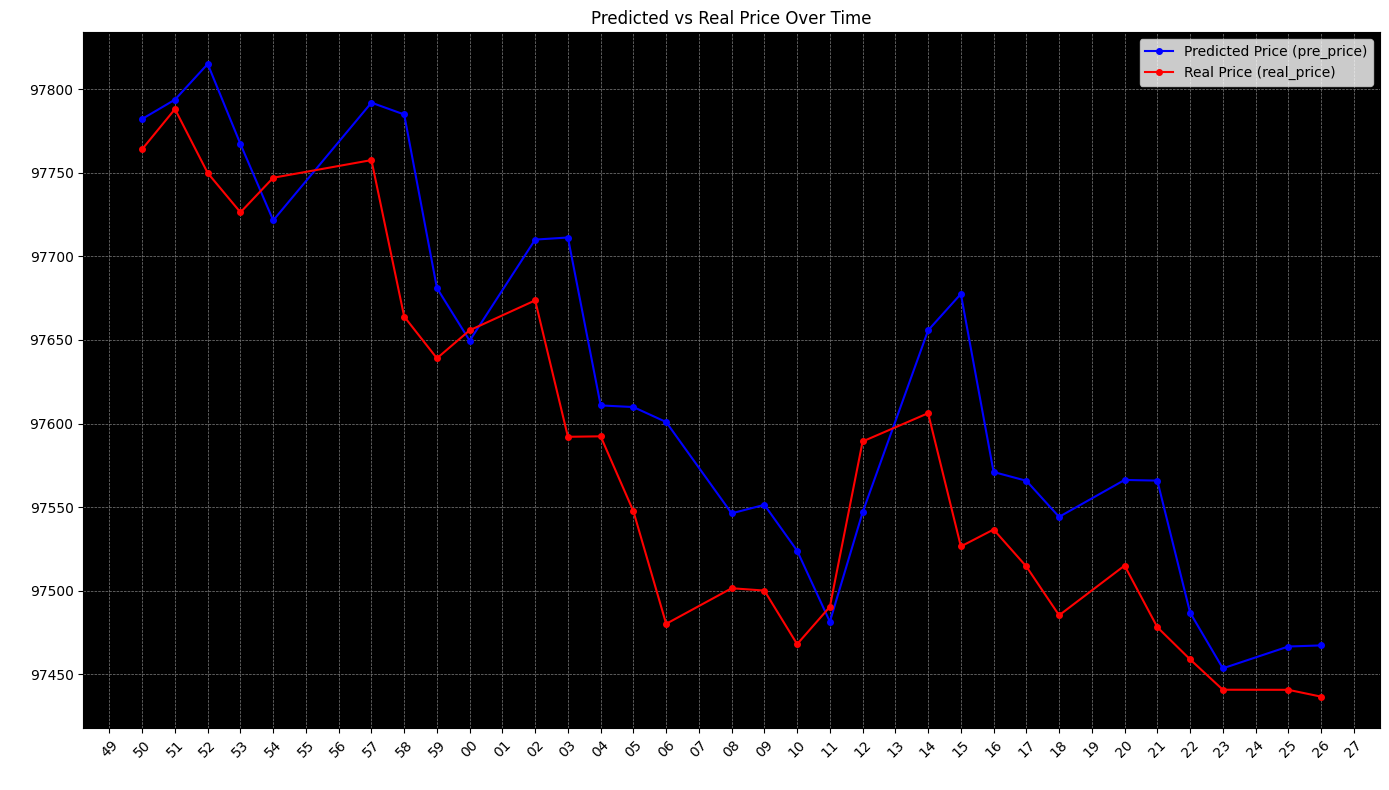

In [ ]:
df_pre_6 = produce_predictions(model_16,scaled_prices)
plotting_predictions(df_pre_6[0:30], "model_16.png")

## Model_17 / loss: 2.1813e-05 - 2.5842582545010373e-05

Keep experimenting with reduced layers being increased little by little

`4 Layers;`

**LSTM** (10, input_shape=(lookback(240), 7), return_sequences=True, activation='tanh),

**LSTM** (10, return_sequences=False, activation='tanh'),

**Dense** (10, activation='relu')

**Dense** (1),

**`Optimizer = Adam(0.001)`**

In [ ]:
model_17 = Sequential([
    LSTM(10, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(10, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_17")
model_17.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_17.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_18 / loss: 1.9813e-05 - 2.3184873498394154e-05
Reducing all layers down. to input columns.

`4 Layers;`

**LSTM** (7, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),

**LSTM** (7, return_sequences=False, activation='tanh'),

**Dense** (5, activation='relu')

**Dense** (1),

**`Optimizer = Adam(0.01)`**

In [ ]:
model_18 = Sequential([
    LSTM(7, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(7, return_sequences=False, activation='tanh'),
    Dense(5, activation='relu'),
    Dense(1)
],name="model_18")
model_18.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_18.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_19 / loss: 5.4937e-05 - val_loss: 5.8070e-05
Learning rate 0.001

`4 Layers;`

**LSTM** (7, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),

**LSTM** (7, return_sequences=False, activation='tanh'),

**Dense** (5, activation='relu')

**Dense** (1),

**`Optimizer = Adam(0.001)`**

In [ ]:
model_19 = Sequential([
    LSTM(7, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(7, return_sequences=False, activation='tanh'),
    Dense(5, activation='relu'),
    Dense(1)
],name="model_19")
model_19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_19.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - loss: 0.0492 - val_loss: 3.0466e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - loss: 1.5915e-04 - val_loss: 1.5909e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 1.3864e-04 - val_loss: 1.4810e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 1.4470e-04 - val_loss: 1.3589e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 1.3436e-04 - val_loss: 1.9310e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - loss: 1.2529e-04 - val_loss: 1.3275e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 1.1658e-04 - val_loss: 1.2155e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - loss: 1.2112e-04 - val_loss: 1.4281e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - loss: 1.1213e-04 - val_loss: 2.4890e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 2.2809e-04 - val_loss: 1.7300e-04
Epoch 11/50
220/220 ━━━━━━━━━━━━━

### Pred

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


<ipython-input-69-90f233920be6>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pre = pd.concat([df_pre, new_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-62-69a135362a22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

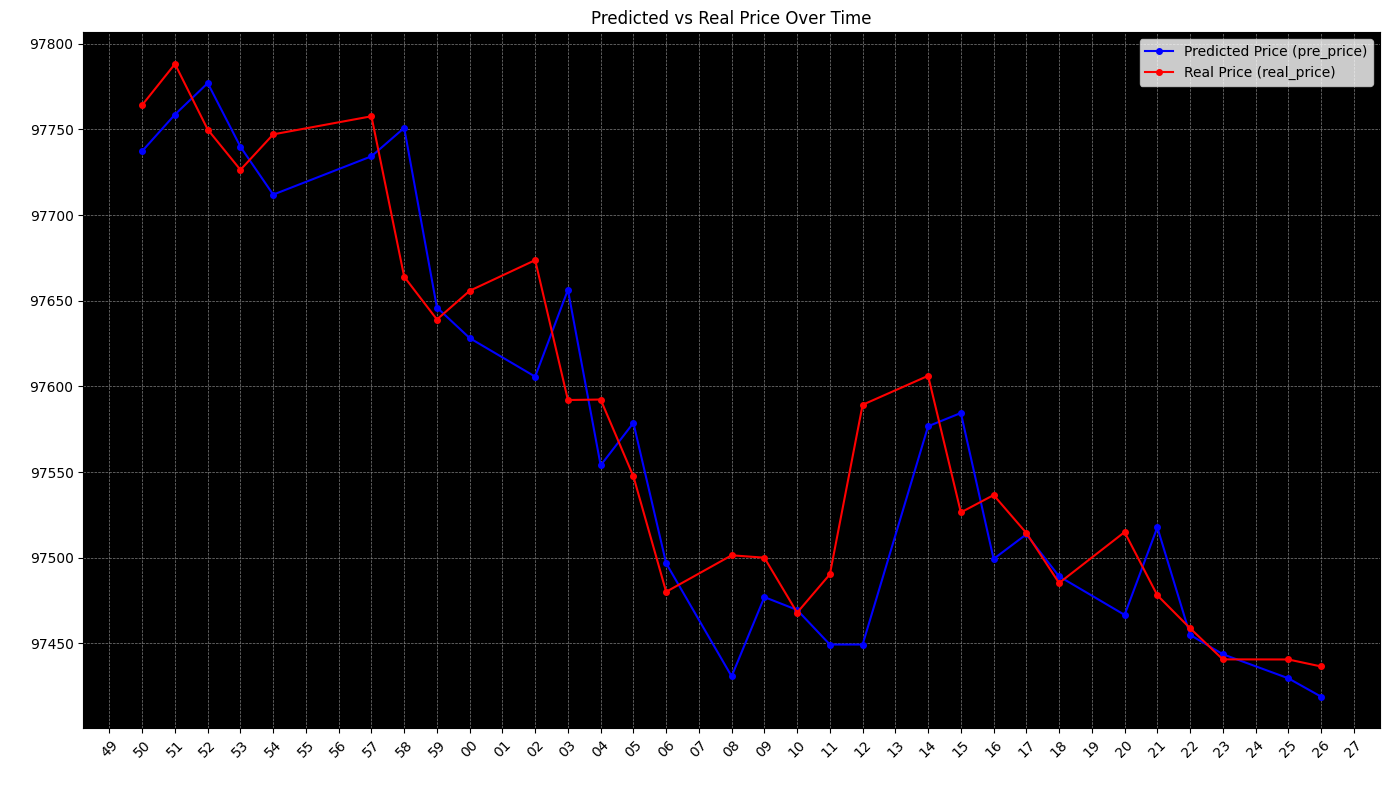

In [ ]:
a = model_19
df_pre_6 = produce_predictions(a,scaled_prices)
plotting_predictions(df_pre_6[0:30], f"{a.name}.png")

## Model_20 / loss: 4.9035e-05 - 5.8866724430117756e-05

Let's add 2 more Dense Layer

`4 Layers;`

**LSTM** (10, input_shape=(lookback(240), 7), return_sequences=True, activation='tanh),

**LSTM** (10, return_sequences=False, activation='tanh'),

**Dense** (10, activation='relu')

**Dense** (1),

**`Optimizer = Adam(0.001)`**

In [ ]:
model_20 = Sequential([
    LSTM(10, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(10, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_20")
model_20.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_20.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_21 / loss: 2.5887e-05 - 2.8959577321074903e-05
Adding 2 times to each layer = 7-7-5

`4 Layers;`

**LSTM** (14, input_shape=(lookback(240), 7), return_sequences=True, activation='tanh),

**LSTM** (14, return_sequences=False, activation='tanh'),

**Dense** (10, activation='relu')

**Dense** (1),

**`Optimizer = Adam(0.01)`**

In [ ]:
model_21 = Sequential([
    LSTM(14, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(14, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_21")
model_21.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_21.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Save Model

In [ ]:
a.save(f"{a.name}.h5")
files.download(f"{a.name}.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>